# STIPS Basic Tutorial

If you prefer to work within a Jupyter notebook, this notebook will follow the same processes as the Basic Tutorial to create a STIPS observation. Like the Basic Tutorial, it assumes that you already have STIPS installed; see [Installing STIPS](https://stsci-stips.readthedocs.io/en/latest/installation.html) in the STIPS documentation if not.

## Importing STIPS and checking the STIPS environment

In order to use STIPS, you must have several sets of data files installed ([Installing STIPS](https://stsci-stips.readthedocs.io/en/latest/installation.html) contains instructions on doing this). In order to test your STIPS installation, STIPS includes an environment report utility that shows which version of STIPS you have installed, as well as the versions of the most important support packages that STIPS uses. When you run the cell below, you should get output something like this:

> STIPS Version x.y.z with Data Version x.y.z at /Some/Path/To/stips_data
>
> STIPS Grid Generated with x.y.z
>
> Pandeia Version a.b.c with Data Version a.b.c at /Some/Path/To/pandeia_refdata
>
> Webbpsf Version d.e.f with Data Version d.e.f at /Some/Path/To/WEBBPSF_PATH

In [1]:
import stips

print(stips.__env__report__)

STIPS Version 2.0.0 with Data Version 1.0.9 at /Users/halkowsi/STScI-STIPS/ref_data/stips_data.
	STIPS Grid Generated with 1.0.8
Pandeia Version 1.7 with Data Version 1.7 at /Users/halkowsi/STScI-STIPS/ref_data/pandeia_data-1.7_roman.
Webbpsf Version 1.0.0 with Data Version 1.0.0 at /Users/halkowsi/STScI-STIPS/ref_data/webbpsf-data.



## Setting up some Basics

STIPS allows you to set up some basic elements of your observation and pass them when creating and running observations. The section below shows one way to set these up.

In [3]:
obs_prefix = 'notebook_example'
obs_ra = 150.0
obs_dec = -2.5

## Creating a Scene to Observe

STIPS contains functions to generate stellar populations as well as background galaxies. These functions are all present in the `SceneModule` class. In order to know what sort of populations to generate, the Scene Module requires input dictionaries to specify population parameters. In this example, we will create the following:

* A stellar population representing a globular cluster with
  * 10,000 stars
  * An age of 7.5 billion years
  * A metallicity of -2.0
  * A Salpeter IMF with alpha=-2.35
  * A binary fraction of 10%
  * A clustered distribution (higher-mass stars closer to the population centre)
  * An inverse power-law distribution
  * A radius of 100 parsecs
  * A distance of 10 kpc
  * No offset from the centre of the scene being created
* A collection of background galaxies with
  * 10 galaxies
  * Redshifts between 0 and 0.2
  * Radii between 0.01 and 2.0 arcsec
  * V-band surface brightness magnitudes between 28 and 24
  * Uniform spatial distribution (unclustered) over 200 arcsec
  * No offset from the center of the scene being created
  

##### Note: 
Background galaxies are available in STIPS, but are neither supported nor tested.
  

In [4]:
from stips.scene_module import SceneModule

scm = SceneModule(out_prefix=obs_prefix, ra=obs_ra, dec=obs_dec)

stellar_parameters = {
                      'n_stars': 10000,
                      'age_low': 7.5e12, 
                      'age_high': 7.5e12,
                      'z_low': -2.0, 
                      'z_high': -2.0,
                      'imf': 'salpeter', 
                      'alpha': -2.35,
                      'binary_fraction': 0.1,
                      'clustered': True,
                      'distribution': 'invpow',
                      'radius': 100.0, 
                      'radius_units': 'pc',
                      'distance_low': 10.0, 
                      'distance_high': 10.0,
                      'offset_ra': 0.0, 
                      'offset_dec': 0.0
                     }

stellar_cat_file = scm.CreatePopulation(stellar_parameters)
print("Stellar population saved to file {}".format(stellar_cat_file))

galaxy_parameters = {
                     'n_gals': 10,
                     'z_low': 0.0, 
                     'z_high': 0.2,
                     'rad_low': 0.01, 
                     'rad_high': 2.0,
                     'sb_v_low': 28.0, 
                     'sb_v_high': 24.0,
                     'distribution': 'uniform', 
                     'clustered': False,
                     'radius': 200.0, 
                     'radius_units': 'arcsec',
                     'offset_ra': 0.0, 
                     'offset_dec': 0.0
                    }

galaxy_cat_file = scm.CreateGalaxies(galaxy_parameters)
print("Galaxy population saved to file {}".format(galaxy_cat_file))



2022-10-31 12:12:21,713 INFO: Creating catalogue /Users/halkowsi/STScI-STIPS/notebooks/notebook_example_stars_000.fits
2022-10-31 12:12:21,714 INFO: Creating age and metallicity numbers
2022-10-31 12:12:21,715 INFO: Created age and metallicity numbers
2022-10-31 12:12:21,716 INFO: Creating stars
2022-10-31 12:12:21,716 INFO: Age 1.35e+10
2022-10-31 12:12:21,717 INFO: Metallicity -2.000000
2022-10-31 12:12:21,718 INFO: Creating 10000 stars


Log level: INFO


2022-10-31 12:12:22,172 INFO: Creating 10000 objects, max radius 100.0, function invpow, scale 2.8
2022-10-31 12:12:22,276 INFO: Chunk 1: 10976 stars
2022-10-31 12:12:22,348 INFO: Done creating catalogue
2022-10-31 12:12:22,349 INFO: Creating catalogue /Users/halkowsi/STScI-STIPS/notebooks/notebook_example_gals_000.fits
2022-10-31 12:12:22,350 INFO: Wrote preamble
2022-10-31 12:12:22,350 INFO: Parameters are: {'n_gals': 10, 'z_low': 0.0, 'z_high': 0.2, 'rad_low': 0.01, 'rad_high': 2.0, 'sb_v_low': 28.0, 'sb_v_high': 24.0, 'distribution': 'uniform', 'clustered': False, 'radius': 200.0, 'radius_units': 'arcsec', 'offset_ra': 0.0, 'offset_dec': 0.0}
2022-10-31 12:12:22,352 INFO: Making Co-ordinates
2022-10-31 12:12:22,353 INFO: Creating 10 objects, max radius 200.0, function uniform, scale 2.8
2022-10-31 12:12:22,354 INFO: Converting Co-ordinates into RA,DEC
2022-10-31 12:12:22,374 INFO: Done creating catalogue


Stellar population saved to file /Users/halkowsi/STScI-STIPS/notebooks/notebook_example_stars_000.fits
Galaxy population saved to file /Users/halkowsi/STScI-STIPS/notebooks/notebook_example_gals_000.fits


## Creating a STIPS observation

Once a scene has been created, it's possible to observe that scene as many times as you wish (and from as many places as you wish, although obviously any observation that doesn't include at least some of the scene will simply be an empty exposure). In this case, we create a single Roman WFI observation.

STIPS uses a bit of specialialized terminology to describe its observations. In particular:

* An *observation* is a set of exposures with a single instrument (e.g. Roman WFI), one or more filters (where each
  exposure in the observation will be repeated for every included filter), some number of the instrument's 
  detectors (for WFI between 1 and 18), where each exposure in the observation will be repeated, with the 
  appropriate inter-detector offset, for every included detector, a single chosen sky background value, and a  
  single exposure time (applied to each exposure in the observation), and one or more offsets.
* An *offset* is a single telescope pointing. For each offset specified in the observation, an exposure will be 
  created for each detector and each filter at the offset. STIPS may, optionally, create one or more mosaics at 
  each offset, with a single mosaic including all detectors with the same filter. In addition, STIPS can create a 
  single combined mosaic for each filter in the combined Observation.

In this case, we will create an observation with:

* Roman WFI F129
* 1 detector
* No distortion
* A sky background of 0.15 counts/s/pixel
* The ID 1
* An exposure time of 1000 seconds

We will use a single offset with:

* An ID of 1
* No centering (if an offset is centred then, for a multi-detector observation, each detector is centred on the   
  offset co-ordinates individually rather than the instrument as a whole being centred there)
* No change in RA, DEC, or PA from the centre of the observation

and the following residual settings:

* Flatfield residual: off
* Dark current residual: off
* Cosmic ray removal residual: off
* Poisson noise residual: on
* Readnoise residual: on


In [5]:
from stips.observation_module import ObservationModule

offset = {
          'offset_id': 1,
          'offset_centre': False,
          'offset_ra': 0.0,
          'offset_dec': 0.0,
          'offset_pa': 0.0
         }

residuals = {
             'residual_flat': False,
             'residual_dark': False,
             'residual_cosmic': False,
             'residual_poisson': True,
             'residual_readnoise': True,
            }

observation_parameters = {
                          'instrument': 'WFI',
                          'filters': ['F129'],
                          'detectors': 1,
                          'distortion': False,
                          'background': 0.15,
                          'observations_id': 1,
                          'exptime': 1000,
                          'offsets': [offset]
                         }

obm = ObservationModule(observation_parameters, out_prefix=obs_prefix, ra=obs_ra, dec=obs_dec, residuals=residuals)


2022-10-31 12:42:37,883 INFO: Got offsets as [{'offset_id': 1, 'offset_centre': False, 'offset_ra': 0.0, 'offset_dec': 0.0, 'offset_pa': 0.0}]
2022-10-31 12:42:37,938 INFO: Adding observation with filter F129 and offset (0.0,0.0,0.0)
2022-10-31 12:42:37,939 INFO: Added 1 observations
2022-10-31 12:42:38,048 INFO: WFI with 1 detectors. Central offset (0.0, 0.0, 0.0)


Finally, we call nextObservation() -– this function is used to move between different combinations of offset and filter.  It must be called once in order to initialize the observation module to the first observatiom before adding catalogues.

In [6]:
obm.nextObservation()

2022-10-31 12:42:40,453 INFO: Initializing Observation 0 of 1
2022-10-31 12:42:40,455 INFO: Observation Filter is F129
2022-10-31 12:42:40,456 INFO: Observation (RA,DEC) = (150.0,-2.5) with PA=0.0
2022-10-31 12:42:40,457 INFO: Resetting
2022-10-31 12:42:40,457 INFO: Returning background 0.15.
2022-10-31 12:42:40,458 INFO: Creating Detector SCA01 with (RA,DEC,PA) = (150.0,-2.5,0.0)
2022-10-31 12:42:40,459 INFO: Creating Detector SCA01 with offset (0.0,0.0)
2022-10-31 12:42:40,525 INFO: Creating Instrument with Configuration {'aperture': 'imaging', 'disperser': None, 'filter': 'f129', 'instrument': 'wfi', 'mode': 'imaging'}


Creating pandeia instrument roman.wfi.imaging


2022-10-31 12:42:40,772 INFO: SCA01: (RA, DEC, PA) := (150.0, -2.5, 0.0), detected as (150.0, -2.5, 0.0)
2022-10-31 12:42:40,773 INFO: Detector SCA01 created
2022-10-31 12:42:40,774 INFO: Reset Instrument


0

## Observing the Scene

In order to observe the scene, we must add the scene catalogues created above to it, add in error residuals, and finalize the observation. In so doing, we create output catalogues which are taken from the input catalogues, but only contain the sources visible to the detectors, and convert source brightnesses into units of counts/s for the detectors.

In [7]:
output_stellar_catalogues = obm.addCatalogue(stellar_cat_file)
output_galaxy_catalogues = obm.addCatalogue(galaxy_cat_file)

print("Output Catalogues are {} and {}.".format(output_stellar_catalogues, output_galaxy_catalogues))

psf_file = obm.addError()

print("PSF File is {}".format(psf_file))

fits_file, mosaic_file, params = obm.finalize(mosaic=False)

print("Output FITS file is {}".format(fits_file))
print("Output Mosaic File is {}".format(mosaic_file))
print("Observation Parameters are {}".format(params))

2022-10-31 12:42:45,325 INFO: Running catalogue /Users/halkowsi/STScI-STIPS/notebooks/notebook_example_stars_000.fits
2022-10-31 12:42:45,326 INFO: Adding catalogue /Users/halkowsi/STScI-STIPS/notebooks/notebook_example_stars_000.fits
2022-10-31 12:42:45,347 INFO: Converting phoenix catalogue
2022-10-31 12:42:45,348 INFO: Preparing output table
2022-10-31 12:42:45,385 INFO: Converting chunk 2
2022-10-31 12:42:45,386 INFO: Converting Phoenix Table to Internal format
2022-10-31 12:42:45,388 INFO: 1 datasets
2022-10-31 12:42:45,793 INFO: Finished converting catalogue to internal format
2022-10-31 12:42:45,793 INFO: Adding catalogue to detector SCA01
2022-10-31 12:42:45,794 INFO: Adding catalogue notebook_example_stars_000_01_conv_F129.fits to AstroImage SCA01
2022-10-31 12:42:45,816 INFO: Determining pixel co-ordinates
2022-10-31 12:42:45,819 INFO: Keeping 5251 items
2022-10-31 12:42:45,822 INFO: Writing 5251 stars
2022-10-31 12:42:45,823 INFO: Adding 5251 point sources to AstroImage SCA0


Running instrument: WFI, filter: F129
  Running detector: SCA01
    Position 1/9: (0, 0) pixels


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (0.0, 37.0)
Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (0.0, 37.0)
Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (0.0, 37.0)
Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (0.0, 37.0)
Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (0.0, 37.0)
Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (0.0, 37.0)
Attempted to get aberrations at field point (0, 0) which i

    Position 2/9: (0, 2048) pixels
    Position 3/9: (0, 4095) pixels
    Position 4/9: (2048, 0) pixels


Attempted to get aberrations at field point (2048, 0) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0, 37.0)
Attempted to get aberrations at field point (2048, 0) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0, 37.0)
Attempted to get aberrations at field point (2048, 0) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0, 37.0)
Attempted to get aberrations at field point (2048, 0) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0, 37.0)
Attempted to get aberrations at field point (2048, 0) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0, 37.0)
Attempted to get aberrations at field point (2048, 0) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0, 37.0)
Attempted to get aberr

    Position 5/9: (2048, 2048) pixels
    Position 6/9: (2048, 4095) pixels
    Position 7/9: (4095, 0) pixels


Attempted to get aberrations at field point (4095, 0) which is outside the range of the reference data; approximating to nearest input grid point
Attempted to get aberrations at field point (4095, 0) which is outside the range of the reference data; approximating to nearest input grid point
Attempted to get aberrations at field point (4095, 0) which is outside the range of the reference data; approximating to nearest input grid point
Attempted to get aberrations at field point (4095, 0) which is outside the range of the reference data; approximating to nearest input grid point
Attempted to get aberrations at field point (4095, 0) which is outside the range of the reference data; approximating to nearest input grid point
Attempted to get aberrations at field point (4095, 0) which is outside the range of the reference data; approximating to nearest input grid point
Attempted to get aberrations at field point (4095, 0) which is outside the range of the reference data; approximating to nea

    Position 8/9: (4095, 2048) pixels


Attempted to get aberrations at field point (4095, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (4084.50759122653, 2047.9974308499575)
Attempted to get aberrations at field point (4095, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (4084.50759122653, 2047.9974308499575)
Attempted to get aberrations at field point (4095, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (4084.50759122653, 2047.9974308499575)
Attempted to get aberrations at field point (4095, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (4084.50759122653, 2047.9974308499575)
Attempted to get aberrations at field point (4095, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (4084.50759122653, 2047.9974308499575)
Attempted to get aberrations at field point (4095,

    Position 9/9: (4095, 4095) pixels


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4084.0063669666697, 4094.9973081211965)
Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4084.0063669666697, 4094.9973081211965)
Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4084.0063669666697, 4094.9973081211965)
Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4084.0063669666697, 4094.9973081211965)
Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4084.0063669666697, 4094.9973081211965)
Attempted to get aberrations at field po

  Saving file: /Users/halkowsi/STScI-STIPS/ref_data/stips_data/psf_cache/psf_WFI_2.0.0_F129_sca01.fits


2022-10-31 12:43:54,357 INFO: Adding point source 1 to AstroImage 2065.2270808370067,2064.820070767493
2022-10-31 12:43:54,374 INFO: Adding point source 2 to AstroImage 2065.6569240658496,2065.6302332360383
2022-10-31 12:43:54,391 INFO: Adding point source 3 to AstroImage 2061.9339118532866,2065.0564241617158
2022-10-31 12:43:54,407 INFO: Adding point source 4 to AstroImage 2064.6197281424224,2067.869897244649
2022-10-31 12:43:54,423 INFO: Adding point source 5 to AstroImage 2071.26760955535,2066.1638746144295
2022-10-31 12:43:54,440 INFO: Adding point source 6 to AstroImage 2058.1773488634162,2064.7014952453565
2022-10-31 12:43:54,456 INFO: Adding point source 7 to AstroImage 2065.6863557260035,2075.2309041642216
2022-10-31 12:43:54,471 INFO: Adding point source 8 to AstroImage 2069.529106432973,2054.4713806325085
2022-10-31 12:43:54,486 INFO: Adding point source 9 to AstroImage 2061.821400643176,2064.247162241914
2022-10-31 12:43:54,502 INFO: Adding point source 10 to AstroImage 2053

2022-10-31 12:43:55,516 INFO: Adding point source 81 to AstroImage 2088.8802847930874,2109.8134290723224
2022-10-31 12:43:55,529 INFO: Adding point source 82 to AstroImage 2101.747480471263,2095.5414346026214
2022-10-31 12:43:55,542 INFO: Adding point source 83 to AstroImage 2037.2341271610092,2056.5123938345696
2022-10-31 12:43:55,555 INFO: Adding point source 84 to AstroImage 2052.5568965696903,2048.597687761355
2022-10-31 12:43:55,570 INFO: Adding point source 85 to AstroImage 2076.9110044877525,2111.928198407102
2022-10-31 12:43:55,585 INFO: Adding point source 86 to AstroImage 2029.975154355118,2053.587247428624
2022-10-31 12:43:55,599 INFO: Adding point source 87 to AstroImage 2026.631835266559,2024.8660058639996
2022-10-31 12:43:55,614 INFO: Adding point source 88 to AstroImage 2073.097309889027,2064.223428597295
2022-10-31 12:43:55,629 INFO: Adding point source 89 to AstroImage 2080.7960180859473,2104.0199004196
2022-10-31 12:43:55,644 INFO: Adding point source 90 to AstroImage

2022-10-31 12:43:56,640 INFO: Adding point source 160 to AstroImage 2080.9601292286625,2045.107909647315
2022-10-31 12:43:56,652 INFO: Adding point source 161 to AstroImage 2052.0554971442293,2064.467721126904
2022-10-31 12:43:56,665 INFO: Adding point source 162 to AstroImage 2060.560586198928,2071.565778267061
2022-10-31 12:43:56,678 INFO: Adding point source 163 to AstroImage 2077.0858525760077,2089.0039819015187
2022-10-31 12:43:56,692 INFO: Adding point source 164 to AstroImage 2090.2165717909525,2127.4705257060236
2022-10-31 12:43:56,707 INFO: Adding point source 165 to AstroImage 2066.4067075886815,2037.8761140397855
2022-10-31 12:43:56,722 INFO: Adding point source 166 to AstroImage 2035.4579168547668,2117.0530512787473
2022-10-31 12:43:56,737 INFO: Adding point source 167 to AstroImage 2031.7845652506314,2168.959600703897
2022-10-31 12:43:56,752 INFO: Adding point source 168 to AstroImage 2120.339093424808,2036.8616930842506
2022-10-31 12:43:56,768 INFO: Adding point source 16

2022-10-31 12:43:57,837 INFO: Adding point source 238 to AstroImage 2065.2879376494934,2064.6582090273514
2022-10-31 12:43:57,851 INFO: Adding point source 239 to AstroImage 2090.538541595565,2045.6600365548625
2022-10-31 12:43:57,864 INFO: Adding point source 240 to AstroImage 1979.9662124852252,2112.2224438909366
2022-10-31 12:43:57,879 INFO: Adding point source 241 to AstroImage 2069.364558019729,2058.589130332531
2022-10-31 12:43:57,894 INFO: Adding point source 242 to AstroImage 1990.523813453617,2054.265785758012
2022-10-31 12:43:57,909 INFO: Adding point source 243 to AstroImage 2077.5001308273827,2122.1138059865693
2022-10-31 12:43:57,924 INFO: Adding point source 244 to AstroImage 2037.3885593547768,2056.390977601096
2022-10-31 12:43:57,939 INFO: Adding point source 245 to AstroImage 2087.8110489878254,1908.7531929136592
2022-10-31 12:43:57,954 INFO: Adding point source 246 to AstroImage 2138.1201199799666,2021.5792210652874
2022-10-31 12:43:57,970 INFO: Adding point source 24

2022-10-31 12:43:59,026 INFO: Adding point source 316 to AstroImage 1984.036156425027,2157.086819794302
2022-10-31 12:43:59,039 INFO: Adding point source 317 to AstroImage 2241.3327792271425,2029.1051946340156
2022-10-31 12:43:59,052 INFO: Adding point source 318 to AstroImage 2127.11770124106,2096.0948160468834
2022-10-31 12:43:59,065 INFO: Adding point source 319 to AstroImage 2164.9947343984077,2145.39674098776
2022-10-31 12:43:59,079 INFO: Adding point source 320 to AstroImage 2017.8024936496245,2103.286126369909
2022-10-31 12:43:59,095 INFO: Adding point source 321 to AstroImage 1946.7406658538353,2048.3097515287154
2022-10-31 12:43:59,110 INFO: Adding point source 322 to AstroImage 2080.012237405293,1909.4665588435764
2022-10-31 12:43:59,125 INFO: Adding point source 323 to AstroImage 2029.023815894292,2265.6552445097254
2022-10-31 12:43:59,140 INFO: Adding point source 324 to AstroImage 2062.924081383729,2064.641337244623
2022-10-31 12:43:59,155 INFO: Adding point source 325 to 

2022-10-31 12:44:00,152 INFO: Adding point source 394 to AstroImage 2153.3711449526504,1958.1950721294834
2022-10-31 12:44:00,165 INFO: Adding point source 395 to AstroImage 1917.7556109087523,2281.4871727933664
2022-10-31 12:44:00,178 INFO: Adding point source 396 to AstroImage 1990.1975105674885,2153.309735470164
2022-10-31 12:44:00,192 INFO: Adding point source 397 to AstroImage 2244.4159786855726,2077.0911337845796
2022-10-31 12:44:00,207 INFO: Adding point source 398 to AstroImage 1936.1347861648037,2278.6649993234714
2022-10-31 12:44:00,221 INFO: Adding point source 399 to AstroImage 2244.2578196532563,2258.5867657396047
2022-10-31 12:44:00,236 INFO: Adding point source 400 to AstroImage 2015.3930063055307,1840.188847598824
2022-10-31 12:44:00,252 INFO: Adding point source 401 to AstroImage 2158.999602672519,1985.0290618499962
2022-10-31 12:44:00,267 INFO: Adding point source 402 to AstroImage 1956.242322582441,2228.8089952325654
2022-10-31 12:44:00,282 INFO: Adding point source 

2022-10-31 12:44:01,418 INFO: Adding point source 472 to AstroImage 1800.7111940114205,1898.7058155384175
2022-10-31 12:44:01,433 INFO: Adding point source 473 to AstroImage 2014.6423464308664,2093.815218251889
2022-10-31 12:44:01,450 INFO: Adding point source 474 to AstroImage 1783.1935233745915,2030.4156399705346
2022-10-31 12:44:01,467 INFO: Adding point source 475 to AstroImage 2326.9268287394407,2054.609266680497
2022-10-31 12:44:01,484 INFO: Adding point source 476 to AstroImage 2353.055655970449,1962.5878348119331
2022-10-31 12:44:01,502 INFO: Adding point source 477 to AstroImage 1779.343254708429,1966.9839547004553
2022-10-31 12:44:01,519 INFO: Adding point source 478 to AstroImage 1877.2093928604945,2242.194141685401
2022-10-31 12:44:01,535 INFO: Adding point source 479 to AstroImage 2092.895217675234,1917.6202060680982
2022-10-31 12:44:01,552 INFO: Adding point source 480 to AstroImage 2119.3524148313263,2235.010783083087
2022-10-31 12:44:01,568 INFO: Adding point source 481

2022-10-31 12:44:02,565 INFO: Adding point source 550 to AstroImage 1750.287828972746,1893.1338199620202
2022-10-31 12:44:02,578 INFO: Adding point source 551 to AstroImage 1963.7439499052757,1805.1606760187717
2022-10-31 12:44:02,592 INFO: Adding point source 552 to AstroImage 1949.8211690508558,2163.984140755943
2022-10-31 12:44:02,607 INFO: Adding point source 553 to AstroImage 2248.4509143272476,2165.0913253360377
2022-10-31 12:44:02,623 INFO: Adding point source 554 to AstroImage 2302.945495788642,2382.157514116464
2022-10-31 12:44:02,638 INFO: Adding point source 555 to AstroImage 2155.9654857627097,2213.750482082373
2022-10-31 12:44:02,653 INFO: Adding point source 556 to AstroImage 2067.5496613803043,2024.149446860389
2022-10-31 12:44:02,668 INFO: Adding point source 557 to AstroImage 2135.627698772507,2331.7636194292004
2022-10-31 12:44:02,683 INFO: Adding point source 558 to AstroImage 2051.323813283047,1804.9382129333462
2022-10-31 12:44:02,699 INFO: Adding point source 559 

2022-10-31 12:44:03,698 INFO: Adding point source 628 to AstroImage 1739.9926231696784,2298.6402473870735
2022-10-31 12:44:03,711 INFO: Adding point source 629 to AstroImage 2202.441206664865,2455.9005288247045
2022-10-31 12:44:03,724 INFO: Adding point source 630 to AstroImage 2099.589761423378,2058.905041462317
2022-10-31 12:44:03,738 INFO: Adding point source 631 to AstroImage 2405.5846273463476,2300.0030911975914
2022-10-31 12:44:03,752 INFO: Adding point source 632 to AstroImage 2073.1132773206214,2465.091062883233
2022-10-31 12:44:03,767 INFO: Adding point source 633 to AstroImage 2192.494032110947,2275.7559844916545
2022-10-31 12:44:03,783 INFO: Adding point source 634 to AstroImage 1751.5729826555923,2048.0740101772617
2022-10-31 12:44:03,798 INFO: Adding point source 635 to AstroImage 1963.0502863332274,1781.3945371828227
2022-10-31 12:44:03,813 INFO: Adding point source 636 to AstroImage 1977.4587475126464,2022.508895333747
2022-10-31 12:44:03,828 INFO: Adding point source 63

2022-10-31 12:44:04,808 INFO: Adding point source 706 to AstroImage 1981.4245554363229,2279.1068328200768
2022-10-31 12:44:04,821 INFO: Adding point source 707 to AstroImage 2185.8714791458387,1969.099578165437
2022-10-31 12:44:04,834 INFO: Adding point source 708 to AstroImage 2217.474054947796,1996.1822226868526
2022-10-31 12:44:04,850 INFO: Adding point source 709 to AstroImage 2182.513248542658,1898.3595975350163
2022-10-31 12:44:04,864 INFO: Adding point source 710 to AstroImage 2155.6501040715466,2517.9016867681985
2022-10-31 12:44:04,879 INFO: Adding point source 711 to AstroImage 2505.8680793917247,2114.394484540674
2022-10-31 12:44:04,894 INFO: Adding point source 712 to AstroImage 2025.3788551106986,1976.3057120063975
2022-10-31 12:44:04,910 INFO: Adding point source 713 to AstroImage 2383.459229308437,2052.6024992521266
2022-10-31 12:44:04,925 INFO: Adding point source 714 to AstroImage 1712.8805561860513,2257.1699339330708
2022-10-31 12:44:04,941 INFO: Adding point source 7

2022-10-31 12:44:05,926 INFO: Adding point source 784 to AstroImage 2413.8978576003533,1718.1579507771276
2022-10-31 12:44:05,938 INFO: Adding point source 785 to AstroImage 1688.49783217555,1936.1651636446645
2022-10-31 12:44:05,951 INFO: Adding point source 786 to AstroImage 1987.1565278611702,2066.4486556353922
2022-10-31 12:44:05,966 INFO: Adding point source 787 to AstroImage 2051.650762473449,2579.891461003984
2022-10-31 12:44:05,981 INFO: Adding point source 788 to AstroImage 2151.105200166397,2009.0624492370212
2022-10-31 12:44:05,996 INFO: Adding point source 789 to AstroImage 2024.0729556825484,2105.5290886129715
2022-10-31 12:44:06,011 INFO: Adding point source 790 to AstroImage 1837.4408478225118,2411.8863710965
2022-10-31 12:44:06,027 INFO: Adding point source 791 to AstroImage 1563.6746674446051,2081.8598627343354
2022-10-31 12:44:06,043 INFO: Adding point source 792 to AstroImage 2180.9024231470876,2017.8700258019496
2022-10-31 12:44:06,059 INFO: Adding point source 793 

2022-10-31 12:44:07,048 INFO: Adding point source 862 to AstroImage 2014.1356050219742,1627.8366869412116
2022-10-31 12:44:07,062 INFO: Adding point source 863 to AstroImage 2101.3176419926854,1993.1006989800612
2022-10-31 12:44:07,075 INFO: Adding point source 864 to AstroImage 2121.4613896491855,2627.4912598243964
2022-10-31 12:44:07,090 INFO: Adding point source 865 to AstroImage 2277.5454631291727,1833.6188480123383
2022-10-31 12:44:07,105 INFO: Adding point source 866 to AstroImage 1737.3778373104774,2437.0894207512256
2022-10-31 12:44:07,121 INFO: Adding point source 867 to AstroImage 1629.9766006862765,2044.4332068314475
2022-10-31 12:44:07,136 INFO: Adding point source 868 to AstroImage 1727.5009049033079,2035.6372676822548
2022-10-31 12:44:07,152 INFO: Adding point source 869 to AstroImage 1570.877211328292,1963.722915315462
2022-10-31 12:44:07,169 INFO: Adding point source 870 to AstroImage 1643.381585374011,1869.3465985996586
2022-10-31 12:44:07,186 INFO: Adding point source

2022-10-31 12:44:08,190 INFO: Adding point source 940 to AstroImage 2092.34304279073,1658.6861888825504
2022-10-31 12:44:08,203 INFO: Adding point source 941 to AstroImage 2243.538289275673,2154.351416927056
2022-10-31 12:44:08,216 INFO: Adding point source 942 to AstroImage 2124.3974130301217,1909.17048339965
2022-10-31 12:44:08,230 INFO: Adding point source 943 to AstroImage 1910.8806802702886,2018.1820241490698
2022-10-31 12:44:08,244 INFO: Adding point source 944 to AstroImage 1626.1718830656969,1676.7307453330054
2022-10-31 12:44:08,260 INFO: Adding point source 945 to AstroImage 2631.6454636634226,2096.0924846458965
2022-10-31 12:44:08,275 INFO: Adding point source 946 to AstroImage 2120.1841251081487,2119.0312192494644
2022-10-31 12:44:08,292 INFO: Adding point source 947 to AstroImage 2060.027470639712,2087.148775088067
2022-10-31 12:44:08,308 INFO: Adding point source 948 to AstroImage 2068.113306327498,2581.4497064624384
2022-10-31 12:44:08,324 INFO: Adding point source 949 t

2022-10-31 12:44:09,376 INFO: Adding point source 1018 to AstroImage 2185.1179055620473,2204.234238639978
2022-10-31 12:44:09,389 INFO: Adding point source 1019 to AstroImage 1658.2589950010179,2317.002781379315
2022-10-31 12:44:09,402 INFO: Adding point source 1020 to AstroImage 2257.5525022915704,2571.7228060395732
2022-10-31 12:44:09,416 INFO: Adding point source 1021 to AstroImage 2098.0402742693896,1656.0626749703988
2022-10-31 12:44:09,431 INFO: Adding point source 1022 to AstroImage 1524.0229180789725,2432.992652478566
2022-10-31 12:44:09,446 INFO: Adding point source 1023 to AstroImage 2119.7726465894416,2075.1319848622124
2022-10-31 12:44:09,462 INFO: Adding point source 1024 to AstroImage 2470.129862621594,2205.687014455071
2022-10-31 12:44:09,479 INFO: Adding point source 1025 to AstroImage 2626.53337504613,2106.9131103221853
2022-10-31 12:44:09,495 INFO: Adding point source 1026 to AstroImage 2441.90360346929,1509.9850979488392
2022-10-31 12:44:09,510 INFO: Adding point sou

2022-10-31 12:44:10,539 INFO: Adding point source 1096 to AstroImage 2096.70431706669,1717.1916216584364
2022-10-31 12:44:10,553 INFO: Adding point source 1097 to AstroImage 1921.5504077249464,2003.629929331832
2022-10-31 12:44:10,567 INFO: Adding point source 1098 to AstroImage 1462.3575811296942,2204.043815202809
2022-10-31 12:44:10,583 INFO: Adding point source 1099 to AstroImage 1604.9797644185132,1688.9292257521674
2022-10-31 12:44:10,598 INFO: Adding point source 1100 to AstroImage 2415.675707685968,2531.8844228827843
2022-10-31 12:44:10,615 INFO: Adding point source 1101 to AstroImage 1620.8153749622948,2024.820572524613
2022-10-31 12:44:10,632 INFO: Adding point source 1102 to AstroImage 1431.3277414691247,2419.344371209651
2022-10-31 12:44:10,649 INFO: Adding point source 1103 to AstroImage 2033.9585200226616,1360.2772749609458
2022-10-31 12:44:10,666 INFO: Adding point source 1104 to AstroImage 2219.814300278401,1468.4280584237565
2022-10-31 12:44:10,681 INFO: Adding point so

2022-10-31 12:44:11,686 INFO: Adding point source 1174 to AstroImage 2106.8376969678648,1904.9186606772032
2022-10-31 12:44:11,698 INFO: Adding point source 1175 to AstroImage 1742.1049009719025,1591.9024276458213
2022-10-31 12:44:11,713 INFO: Adding point source 1176 to AstroImage 2393.1059387847686,2383.0494321966185
2022-10-31 12:44:11,728 INFO: Adding point source 1177 to AstroImage 1512.3776820121782,2267.3437107316704
2022-10-31 12:44:11,743 INFO: Adding point source 1178 to AstroImage 1534.3281505426655,2527.1949092823957
2022-10-31 12:44:11,759 INFO: Adding point source 1179 to AstroImage 1468.090041947748,1996.3309179293612
2022-10-31 12:44:11,774 INFO: Adding point source 1180 to AstroImage 2840.1552810995954,1983.0706875582646
2022-10-31 12:44:11,790 INFO: Adding point source 1181 to AstroImage 1581.6903563003912,2677.81682266303
2022-10-31 12:44:11,805 INFO: Adding point source 1182 to AstroImage 1969.0624053530746,2423.3635078674915
2022-10-31 12:44:11,820 INFO: Adding poi

2022-10-31 12:44:12,799 INFO: Adding point source 1251 to AstroImage 2543.6652272879674,2563.5680314953497
2022-10-31 12:44:12,813 INFO: Adding point source 1252 to AstroImage 1301.3390549859096,1781.1447455859757
2022-10-31 12:44:12,827 INFO: Adding point source 1253 to AstroImage 1817.8478649998538,1671.6342802689428
2022-10-31 12:44:12,840 INFO: Adding point source 1254 to AstroImage 2032.6098973818778,2087.457112470682
2022-10-31 12:44:12,855 INFO: Adding point source 1255 to AstroImage 1976.2464706050155,2045.1004800020764
2022-10-31 12:44:12,869 INFO: Adding point source 1256 to AstroImage 2398.697502370304,1934.0464434886298
2022-10-31 12:44:12,884 INFO: Adding point source 1257 to AstroImage 2173.8753367453414,2547.7386587786655
2022-10-31 12:44:12,899 INFO: Adding point source 1258 to AstroImage 2847.7004919915153,2150.7227839491397
2022-10-31 12:44:12,913 INFO: Adding point source 1259 to AstroImage 2305.1571019041626,1829.053950876264
2022-10-31 12:44:12,928 INFO: Adding poi

2022-10-31 12:44:13,931 INFO: Adding point source 1329 to AstroImage 2668.153219598839,2291.5956781150953
2022-10-31 12:44:13,943 INFO: Adding point source 1330 to AstroImage 2401.421069633814,2710.678303159344
2022-10-31 12:44:13,957 INFO: Adding point source 1331 to AstroImage 2280.43556397435,2429.8971071298333
2022-10-31 12:44:13,971 INFO: Adding point source 1332 to AstroImage 1640.558718474359,2852.7523231700543
2022-10-31 12:44:13,986 INFO: Adding point source 1333 to AstroImage 2817.302327171759,2472.1711759285345
2022-10-31 12:44:14,001 INFO: Adding point source 1334 to AstroImage 2638.984700007995,1585.862690497383
2022-10-31 12:44:14,016 INFO: Adding point source 1335 to AstroImage 2960.314366919077,2096.720686746839
2022-10-31 12:44:14,031 INFO: Adding point source 1336 to AstroImage 2477.7855585769094,1273.2985230435825
2022-10-31 12:44:14,047 INFO: Adding point source 1337 to AstroImage 1786.18949551143,2154.3766893878133
2022-10-31 12:44:14,063 INFO: Adding point source 

2022-10-31 12:44:15,044 INFO: Adding point source 1407 to AstroImage 1401.1572315490391,2041.9772033983281
2022-10-31 12:44:15,056 INFO: Adding point source 1408 to AstroImage 1438.359478133506,1537.959208308232
2022-10-31 12:44:15,068 INFO: Adding point source 1409 to AstroImage 2593.386695919102,1353.963567550557
2022-10-31 12:44:15,081 INFO: Adding point source 1410 to AstroImage 1270.1517098297572,2431.507050323048
2022-10-31 12:44:15,094 INFO: Adding point source 1411 to AstroImage 1186.6191517825405,2427.8395086364526
2022-10-31 12:44:15,110 INFO: Adding point source 1412 to AstroImage 1375.7403831727781,1486.3251462196604
2022-10-31 12:44:15,126 INFO: Adding point source 1413 to AstroImage 1726.567193099912,2932.3591206050014
2022-10-31 12:44:15,141 INFO: Adding point source 1414 to AstroImage 1292.3004960312064,2092.579143668484
2022-10-31 12:44:15,157 INFO: Adding point source 1415 to AstroImage 1627.8094337612888,1233.7607017392486
2022-10-31 12:44:15,172 INFO: Adding point s

2022-10-31 12:44:16,170 INFO: Adding point source 1485 to AstroImage 1224.531150860987,2637.2236434748447
2022-10-31 12:44:16,183 INFO: Adding point source 1486 to AstroImage 2102.3136023901075,2153.7337064331346
2022-10-31 12:44:16,196 INFO: Adding point source 1487 to AstroImage 2257.7580030795684,2995.207753247369
2022-10-31 12:44:16,210 INFO: Adding point source 1488 to AstroImage 1420.7367344051859,1609.8046141863892
2022-10-31 12:44:16,225 INFO: Adding point source 1489 to AstroImage 2942.2860406542673,2581.464103761858
2022-10-31 12:44:16,241 INFO: Adding point source 1490 to AstroImage 2178.1971666260306,1079.3306767240276
2022-10-31 12:44:16,256 INFO: Adding point source 1491 to AstroImage 1075.4634292591427,2158.8697946085776
2022-10-31 12:44:16,271 INFO: Adding point source 1492 to AstroImage 2309.4812364699533,1123.2283629028873
2022-10-31 12:44:16,287 INFO: Adding point source 1493 to AstroImage 1566.4124887291061,2803.52569242223
2022-10-31 12:44:16,302 INFO: Adding point

2022-10-31 12:44:17,301 INFO: Adding point source 1563 to AstroImage 2582.834416442382,2110.1634488497752
2022-10-31 12:44:17,315 INFO: Adding point source 1564 to AstroImage 2088.2664360803724,2827.7188702831736
2022-10-31 12:44:17,330 INFO: Adding point source 1565 to AstroImage 2104.589543191075,1382.9800943538949
2022-10-31 12:44:17,345 INFO: Adding point source 1566 to AstroImage 2067.8411145384725,2067.898173828545
2022-10-31 12:44:17,360 INFO: Adding point source 1567 to AstroImage 2541.4097154018314,1476.04161488313
2022-10-31 12:44:17,375 INFO: Adding point source 1568 to AstroImage 1444.3403504991957,2317.7768771807396
2022-10-31 12:44:17,391 INFO: Adding point source 1569 to AstroImage 2331.6263332461413,2663.015603252097
2022-10-31 12:44:17,407 INFO: Adding point source 1570 to AstroImage 2282.4590158830356,1286.9189094061949
2022-10-31 12:44:17,422 INFO: Adding point source 1571 to AstroImage 1586.2829748070205,2876.296989776998
2022-10-31 12:44:17,438 INFO: Adding point s

2022-10-31 12:44:18,484 INFO: Adding point source 1641 to AstroImage 1142.6876640179894,1821.4814384236415
2022-10-31 12:44:18,499 INFO: Adding point source 1642 to AstroImage 1835.9736888792663,2355.1639305749472
2022-10-31 12:44:18,515 INFO: Adding point source 1643 to AstroImage 2094.083366187021,2190.1627483834754
2022-10-31 12:44:18,530 INFO: Adding point source 1644 to AstroImage 1012.655016394589,1627.2988087838514
2022-10-31 12:44:18,546 INFO: Adding point source 1645 to AstroImage 938.9234885435335,1901.3523360447834
2022-10-31 12:44:18,563 INFO: Adding point source 1646 to AstroImage 2140.375599841848,1902.4099110355355
2022-10-31 12:44:18,580 INFO: Adding point source 1647 to AstroImage 1490.4170883803263,1198.4368725636446
2022-10-31 12:44:18,597 INFO: Adding point source 1648 to AstroImage 1187.517545534569,2201.8764989934843
2022-10-31 12:44:18,614 INFO: Adding point source 1649 to AstroImage 2043.9498275174565,2007.241832052116
2022-10-31 12:44:18,631 INFO: Adding point 

2022-10-31 12:44:19,633 INFO: Adding point source 1719 to AstroImage 1312.7664450506452,2346.8752916517606
2022-10-31 12:44:19,646 INFO: Adding point source 1720 to AstroImage 3072.8348822876314,2271.3888124512564
2022-10-31 12:44:19,659 INFO: Adding point source 1721 to AstroImage 2589.681151285605,2486.2757095012635
2022-10-31 12:44:19,674 INFO: Adding point source 1722 to AstroImage 2226.196377157449,1660.0338548298523
2022-10-31 12:44:19,689 INFO: Adding point source 1723 to AstroImage 2895.87784654573,2658.576910357813
2022-10-31 12:44:19,704 INFO: Adding point source 1724 to AstroImage 2089.8311731424546,2026.3422435140665
2022-10-31 12:44:19,719 INFO: Adding point source 1725 to AstroImage 951.6208109068207,1683.1288768306033
2022-10-31 12:44:19,734 INFO: Adding point source 1726 to AstroImage 2381.478166968128,2816.344020113801
2022-10-31 12:44:19,749 INFO: Adding point source 1727 to AstroImage 2438.5564011031183,2455.1134360973983
2022-10-31 12:44:19,765 INFO: Adding point so

2022-10-31 12:44:20,808 INFO: Adding point source 1797 to AstroImage 1860.5355358454167,2682.3377466168563
2022-10-31 12:44:20,824 INFO: Adding point source 1798 to AstroImage 1342.2515590947469,1495.8634304753184
2022-10-31 12:44:20,840 INFO: Adding point source 1799 to AstroImage 2522.3608923626334,3080.432129078928
2022-10-31 12:44:20,857 INFO: Adding point source 1800 to AstroImage 2254.357973661725,3009.9353003403103
2022-10-31 12:44:20,875 INFO: Adding point source 1801 to AstroImage 1385.0420654668692,2797.8574135776676
2022-10-31 12:44:20,893 INFO: Adding point source 1802 to AstroImage 1721.9609962498675,3098.777746188264
2022-10-31 12:44:20,910 INFO: Adding point source 1803 to AstroImage 885.421858726914,1689.7431788506722
2022-10-31 12:44:20,927 INFO: Adding point source 1804 to AstroImage 2542.7324446240527,2095.823825032593
2022-10-31 12:44:20,943 INFO: Adding point source 1805 to AstroImage 841.0432221819508,2019.5960674812536
2022-10-31 12:44:20,959 INFO: Adding point s

2022-10-31 12:44:21,952 INFO: Adding point source 1875 to AstroImage 1856.9146602303508,1658.8396689758924
2022-10-31 12:44:21,964 INFO: Adding point source 1876 to AstroImage 2273.6819313778096,2338.2125735035515
2022-10-31 12:44:21,977 INFO: Adding point source 1877 to AstroImage 1888.4494330818443,2463.857037608279
2022-10-31 12:44:21,992 INFO: Adding point source 1878 to AstroImage 2370.079612299107,934.8850841801541
2022-10-31 12:44:22,008 INFO: Adding point source 1879 to AstroImage 2649.589639479666,2523.712802644589
2022-10-31 12:44:22,024 INFO: Adding point source 1880 to AstroImage 1517.4544287960957,1494.7649667438827
2022-10-31 12:44:22,041 INFO: Adding point source 1881 to AstroImage 2922.199871849167,2534.801473829959
2022-10-31 12:44:22,058 INFO: Adding point source 1882 to AstroImage 2934.3228676890294,2773.8958686288424
2022-10-31 12:44:22,075 INFO: Adding point source 1883 to AstroImage 739.2888875539693,2036.5335949960402
2022-10-31 12:44:22,092 INFO: Adding point so

2022-10-31 12:44:23,081 INFO: Adding point source 1953 to AstroImage 1945.5708541244703,2036.0385886941358
2022-10-31 12:44:23,094 INFO: Adding point source 1954 to AstroImage 1084.2454862816808,1788.6435907693647
2022-10-31 12:44:23,107 INFO: Adding point source 1955 to AstroImage 739.4935128332847,1965.2733336375688
2022-10-31 12:44:23,122 INFO: Adding point source 1956 to AstroImage 2809.183181526061,2930.765851678131
2022-10-31 12:44:23,137 INFO: Adding point source 1957 to AstroImage 2244.344795029702,2479.057453229262
2022-10-31 12:44:23,152 INFO: Adding point source 1958 to AstroImage 3437.0250183643875,2088.034915835522
2022-10-31 12:44:23,168 INFO: Adding point source 1959 to AstroImage 2001.0491947902883,2055.552030185345
2022-10-31 12:44:23,183 INFO: Adding point source 1960 to AstroImage 3193.3047678409584,2393.926358762002
2022-10-31 12:44:23,198 INFO: Adding point source 1961 to AstroImage 2486.7166390879966,1446.477140767974
2022-10-31 12:44:23,213 INFO: Adding point sou

2022-10-31 12:44:24,195 INFO: Adding point source 2031 to AstroImage 1478.4720829504931,2926.139057641456
2022-10-31 12:44:24,208 INFO: Adding point source 2032 to AstroImage 1585.6993071414065,1911.5297308591037
2022-10-31 12:44:24,221 INFO: Adding point source 2033 to AstroImage 840.5853186316428,1460.1578158099098
2022-10-31 12:44:24,233 INFO: Adding point source 2034 to AstroImage 2194.6508283096373,1885.6527157504959
2022-10-31 12:44:24,247 INFO: Adding point source 2035 to AstroImage 1382.5190660901683,1174.552677859136
2022-10-31 12:44:24,262 INFO: Adding point source 2036 to AstroImage 2942.8653122807455,2823.153169716603
2022-10-31 12:44:24,276 INFO: Adding point source 2037 to AstroImage 2022.699394255209,2527.249353770722
2022-10-31 12:44:24,292 INFO: Adding point source 2038 to AstroImage 903.1122962669485,2801.8687007042727
2022-10-31 12:44:24,309 INFO: Adding point source 2039 to AstroImage 730.3967965511729,2254.9548135089913
2022-10-31 12:44:24,326 INFO: Adding point so

2022-10-31 12:44:25,317 INFO: Adding point source 2109 to AstroImage 3445.9369591422906,2594.419570344667
2022-10-31 12:44:25,330 INFO: Adding point source 2110 to AstroImage 1957.6251988707388,1588.4909138085648
2022-10-31 12:44:25,343 INFO: Adding point source 2111 to AstroImage 2943.842154574227,2942.0545407587047
2022-10-31 12:44:25,357 INFO: Adding point source 2112 to AstroImage 656.4944333691294,2598.2643697842204
2022-10-31 12:44:25,372 INFO: Adding point source 2113 to AstroImage 2349.655155438243,2276.5314707081025
2022-10-31 12:44:25,387 INFO: Adding point source 2114 to AstroImage 896.4352227036266,2477.5081632569
2022-10-31 12:44:25,402 INFO: Adding point source 2115 to AstroImage 3152.152298953727,1660.1960725474983
2022-10-31 12:44:25,416 INFO: Adding point source 2116 to AstroImage 2537.0794773631155,649.620982948135
2022-10-31 12:44:25,431 INFO: Adding point source 2117 to AstroImage 3099.6569637522316,2199.01662987854
2022-10-31 12:44:25,446 INFO: Adding point source 

2022-10-31 12:44:26,413 INFO: Adding point source 2187 to AstroImage 3208.791400231421,3083.587228856123
2022-10-31 12:44:26,426 INFO: Adding point source 2188 to AstroImage 2239.5865164075753,2602.02833676809
2022-10-31 12:44:26,440 INFO: Adding point source 2189 to AstroImage 3373.6807672124633,2880.404877443957
2022-10-31 12:44:26,454 INFO: Adding point source 2190 to AstroImage 2927.493624614192,2050.951989161026
2022-10-31 12:44:26,469 INFO: Adding point source 2191 to AstroImage 2798.4036562287642,2800.0433919365005
2022-10-31 12:44:26,484 INFO: Adding point source 2192 to AstroImage 1085.432066751873,3268.393525415911
2022-10-31 12:44:26,500 INFO: Adding point source 2193 to AstroImage 2192.224406108281,547.2158857807922
2022-10-31 12:44:26,515 INFO: Adding point source 2194 to AstroImage 3284.6381053561927,2912.7042706571565
2022-10-31 12:44:26,530 INFO: Adding point source 2195 to AstroImage 2391.065594104367,3402.3795500908864
2022-10-31 12:44:26,545 INFO: Adding point source

2022-10-31 12:44:27,581 INFO: Adding point source 2265 to AstroImage 1272.6576357436065,2299.337494386918
2022-10-31 12:44:27,597 INFO: Adding point source 2266 to AstroImage 1913.4266632349281,3385.4515285002526
2022-10-31 12:44:27,617 INFO: Adding point source 2267 to AstroImage 3593.779456952868,1520.439461976646
2022-10-31 12:44:27,633 INFO: Adding point source 2268 to AstroImage 2693.3580984280734,2729.0987546718616
2022-10-31 12:44:27,648 INFO: Adding point source 2269 to AstroImage 1812.0982657592272,2281.788588587317
2022-10-31 12:44:27,663 INFO: Adding point source 2270 to AstroImage 3661.51095888908,2371.4110002272973
2022-10-31 12:44:27,679 INFO: Adding point source 2271 to AstroImage 2063.446721697775,2054.0830329951327
2022-10-31 12:44:27,695 INFO: Adding point source 2272 to AstroImage 2355.816480854462,3218.22877677448
2022-10-31 12:44:27,711 INFO: Adding point source 2273 to AstroImage 1715.1132156400633,1501.8921238715989
2022-10-31 12:44:27,727 INFO: Adding point sour

2022-10-31 12:44:28,715 INFO: Adding point source 2343 to AstroImage 1391.2557138976226,2941.8012283160624
2022-10-31 12:44:28,728 INFO: Adding point source 2344 to AstroImage 1790.537232754223,742.8414276385763
2022-10-31 12:44:28,742 INFO: Adding point source 2345 to AstroImage 3677.6476025409665,2295.5545528204193
2022-10-31 12:44:28,756 INFO: Adding point source 2346 to AstroImage 1243.9178471237406,2066.643944760493
2022-10-31 12:44:28,771 INFO: Adding point source 2347 to AstroImage 2069.735725568881,2795.84241592175
2022-10-31 12:44:28,787 INFO: Adding point source 2348 to AstroImage 1752.7314959548346,869.1662729084796
2022-10-31 12:44:28,802 INFO: Adding point source 2349 to AstroImage 2290.290315971118,2981.086328481539
2022-10-31 12:44:28,818 INFO: Adding point source 2350 to AstroImage 1281.366096058006,885.1270246259041
2022-10-31 12:44:28,833 INFO: Adding point source 2351 to AstroImage 3334.5853569183464,3184.965263553928
2022-10-31 12:44:28,848 INFO: Adding point source

2022-10-31 12:44:29,823 INFO: Adding point source 2421 to AstroImage 2507.0080896321842,3746.756771464193
2022-10-31 12:44:29,835 INFO: Adding point source 2422 to AstroImage 2531.611190576466,1892.460539925859
2022-10-31 12:44:29,848 INFO: Adding point source 2423 to AstroImage 1487.679200571867,1380.9481081109245
2022-10-31 12:44:29,861 INFO: Adding point source 2424 to AstroImage 3792.338364163103,1853.0246622304885
2022-10-31 12:44:29,874 INFO: Adding point source 2425 to AstroImage 1393.742079958367,3682.4100412483053
2022-10-31 12:44:29,889 INFO: Adding point source 2426 to AstroImage 1811.7075067510204,1766.3401898610691
2022-10-31 12:44:29,904 INFO: Adding point source 2427 to AstroImage 2231.807521392075,1753.0495922635441
2022-10-31 12:44:29,919 INFO: Adding point source 2428 to AstroImage 2251.178623489677,327.2239340249064
2022-10-31 12:44:29,935 INFO: Adding point source 2429 to AstroImage 2251.4337428231333,3804.0697493100533
2022-10-31 12:44:29,950 INFO: Adding point sou

2022-10-31 12:44:31,042 INFO: Adding point source 2499 to AstroImage 497.71398370161637,1212.9845613665366
2022-10-31 12:44:31,055 INFO: Adding point source 2500 to AstroImage 1649.9178327094992,1566.6077564482619
2022-10-31 12:44:31,071 INFO: Adding point source 2501 to AstroImage 3268.3833682707264,872.6215269786167
2022-10-31 12:44:31,086 INFO: Adding point source 2502 to AstroImage 1273.537856243665,1432.1250096091014
2022-10-31 12:44:31,101 INFO: Adding point source 2503 to AstroImage 2462.170998942391,3205.256452185906
2022-10-31 12:44:31,117 INFO: Adding point source 2504 to AstroImage 1070.7135706406013,2639.981315150888
2022-10-31 12:44:31,133 INFO: Adding point source 2505 to AstroImage 3530.6580381355243,3033.3426078324146
2022-10-31 12:44:31,148 INFO: Adding point source 2506 to AstroImage 334.299472766334,2435.5092028348663
2022-10-31 12:44:31,163 INFO: Adding point source 2507 to AstroImage 1580.509376495955,398.33967806250575
2022-10-31 12:44:31,178 INFO: Adding point so

2022-10-31 12:44:32,228 INFO: Adding point source 2577 to AstroImage 2076.3787290382297,3662.5584451388695
2022-10-31 12:44:32,241 INFO: Adding point source 2578 to AstroImage 3757.059646671875,2839.033047148429
2022-10-31 12:44:32,257 INFO: Adding point source 2579 to AstroImage 2154.51088632074,709.5192337804306
2022-10-31 12:44:32,272 INFO: Adding point source 2580 to AstroImage 2276.8534649001576,1364.0500749738508
2022-10-31 12:44:32,289 INFO: Adding point source 2581 to AstroImage 1699.7218059663041,3696.3570191226427
2022-10-31 12:44:32,308 INFO: Adding point source 2582 to AstroImage 1579.5677104205238,1514.7295069376514
2022-10-31 12:44:32,325 INFO: Adding point source 2583 to AstroImage 2003.1420849978522,2649.053786754038
2022-10-31 12:44:32,342 INFO: Adding point source 2584 to AstroImage 1364.2960555788677,891.6149300728321
2022-10-31 12:44:32,358 INFO: Adding point source 2585 to AstroImage 511.5477469896955,1334.4236753404978
2022-10-31 12:44:32,375 INFO: Adding point so

2022-10-31 12:44:33,366 INFO: Adding point source 2655 to AstroImage 829.7827729157616,3562.9447766515177
2022-10-31 12:44:33,379 INFO: Adding point source 2656 to AstroImage 2996.349105588571,1236.163848399343
2022-10-31 12:44:33,393 INFO: Adding point source 2657 to AstroImage 2795.40472872778,1375.7186922623123
2022-10-31 12:44:33,406 INFO: Adding point source 2658 to AstroImage 3356.3413000232604,3420.7431954179474
2022-10-31 12:44:33,420 INFO: Adding point source 2659 to AstroImage 1125.069026850611,3012.958326756565
2022-10-31 12:44:33,435 INFO: Adding point source 2660 to AstroImage 1540.676229652521,2545.912535366062
2022-10-31 12:44:33,450 INFO: Adding point source 2661 to AstroImage 1836.6489083776146,792.6825826868746
2022-10-31 12:44:33,465 INFO: Adding point source 2662 to AstroImage 211.49267855635435,1510.8096906305304
2022-10-31 12:44:33,480 INFO: Adding point source 2663 to AstroImage 1378.4074630706918,1242.3549523680665
2022-10-31 12:44:33,496 INFO: Adding point sour

2022-10-31 12:44:34,476 INFO: Adding point source 2733 to AstroImage 2975.808127166003,519.7464919820188
2022-10-31 12:44:34,489 INFO: Adding point source 2734 to AstroImage 3600.8852958196153,882.296178234385
2022-10-31 12:44:34,503 INFO: Adding point source 2735 to AstroImage 1677.30403909671,1420.3410521372875
2022-10-31 12:44:34,519 INFO: Adding point source 2736 to AstroImage 2203.8404301116293,2860.7619935427847
2022-10-31 12:44:34,534 INFO: Adding point source 2737 to AstroImage 2044.6135116978019,2378.4640152627762
2022-10-31 12:44:34,548 INFO: Adding point source 2738 to AstroImage 2985.2574183015176,3264.8936453126053
2022-10-31 12:44:34,563 INFO: Adding point source 2739 to AstroImage 2168.1076368805825,1889.7220116955032
2022-10-31 12:44:34,578 INFO: Adding point source 2740 to AstroImage 2362.7160536551764,4043.1223959069994
2022-10-31 12:44:34,594 INFO: Adding point source 2741 to AstroImage 2680.3059461696425,3573.7086773401097
2022-10-31 12:44:34,610 INFO: Adding point 

2022-10-31 12:44:35,574 INFO: Adding point source 2811 to AstroImage 2155.454506683037,2185.8548340652574
2022-10-31 12:44:35,586 INFO: Adding point source 2812 to AstroImage 510.5525470775517,3140.935153378122
2022-10-31 12:44:35,599 INFO: Adding point source 2813 to AstroImage 2681.8620145788527,2508.915896378584
2022-10-31 12:44:35,612 INFO: Adding point source 2814 to AstroImage 620.1698762746416,572.6160496613272
2022-10-31 12:44:35,627 INFO: Adding point source 2815 to AstroImage 1783.307302092557,215.99953582091848
2022-10-31 12:44:35,642 INFO: Adding point source 2816 to AstroImage 3278.236922337955,874.8604503989534
2022-10-31 12:44:35,657 INFO: Adding point source 2817 to AstroImage 4066.504246577738,1571.259724517074
2022-10-31 12:44:35,672 INFO: Adding point source 2818 to AstroImage 2040.5980082782148,3937.9229638820602
2022-10-31 12:44:35,687 INFO: Adding point source 2819 to AstroImage 2810.2698187206083,2698.200500805883
2022-10-31 12:44:35,702 INFO: Adding point source

2022-10-31 12:44:36,676 INFO: Adding point source 2889 to AstroImage 942.4495917265187,890.9193610260402
2022-10-31 12:44:36,690 INFO: Adding point source 2890 to AstroImage 1942.8031814491883,3298.8259966354126
2022-10-31 12:44:36,703 INFO: Adding point source 2891 to AstroImage 2081.4617718167515,1990.5586104251292
2022-10-31 12:44:36,718 INFO: Adding point source 2892 to AstroImage 1996.0248731738648,821.3605255216492
2022-10-31 12:44:36,733 INFO: Adding point source 2893 to AstroImage 1585.5035259354554,4116.758800297963
2022-10-31 12:44:36,746 INFO: Adding point source 2894 to AstroImage 2526.932076503255,984.3545664329297
2022-10-31 12:44:36,762 INFO: Adding point source 2895 to AstroImage 1663.29932914828,3575.050596530694
2022-10-31 12:44:36,777 INFO: Adding point source 2896 to AstroImage 122.0373944856201,1129.7338514669273
2022-10-31 12:44:36,792 INFO: Adding point source 2897 to AstroImage 1044.192266813336,2694.486179592872
2022-10-31 12:44:36,807 INFO: Adding point source

2022-10-31 12:44:37,852 INFO: Adding point source 2967 to AstroImage 2946.2450402283575,1798.211674879905
2022-10-31 12:44:37,866 INFO: Adding point source 2968 to AstroImage 2108.7624575670493,2013.270501015972
2022-10-31 12:44:37,879 INFO: Adding point source 2969 to AstroImage 2309.839489896563,2847.3929936611885
2022-10-31 12:44:37,893 INFO: Adding point source 2970 to AstroImage 872.6364327667441,1514.4959186489639
2022-10-31 12:44:37,908 INFO: Adding point source 2971 to AstroImage 1658.777704643334,1426.7979096559175
2022-10-31 12:44:37,922 INFO: Adding point source 2972 to AstroImage 2979.1625603823363,2159.6890099956736
2022-10-31 12:44:37,937 INFO: Adding point source 2973 to AstroImage 1117.169453761011,466.839746989712
2022-10-31 12:44:37,952 INFO: Adding point source 2974 to AstroImage 2870.179778992203,2774.26807952148
2022-10-31 12:44:37,967 INFO: Adding point source 2975 to AstroImage 2141.836457624259,1540.0273852618072
2022-10-31 12:44:37,982 INFO: Adding point source

2022-10-31 12:44:38,956 INFO: Adding point source 3045 to AstroImage 462.75598171900947,1199.4746041761994
2022-10-31 12:44:38,969 INFO: Adding point source 3046 to AstroImage 1302.630434191982,110.14821832239727
2022-10-31 12:44:38,983 INFO: Adding point source 3047 to AstroImage 1916.797670922335,2403.1238509485274
2022-10-31 12:44:38,997 INFO: Adding point source 3048 to AstroImage 1036.1938151301445,653.3867402945402
2022-10-31 12:44:39,012 INFO: Adding point source 3049 to AstroImage 3235.5083012651867,603.5164631867904
2022-10-31 12:44:39,027 INFO: Adding point source 3050 to AstroImage 2023.1087216703647,991.8975886777775
2022-10-31 12:44:39,043 INFO: Adding point source 3051 to AstroImage 2902.898888077569,728.2655911695222
2022-10-31 12:44:39,058 INFO: Adding point source 3052 to AstroImage 1727.6642009344746,3737.979764137278
2022-10-31 12:44:39,074 INFO: Adding point source 3053 to AstroImage 2780.6236607417122,1085.6641677271818
2022-10-31 12:44:39,090 INFO: Adding point so

2022-10-31 12:44:40,071 INFO: Adding point source 3123 to AstroImage 1298.5098069367475,2714.1017126322945
2022-10-31 12:44:40,083 INFO: Adding point source 3124 to AstroImage 3125.541107219865,2247.2899401611808
2022-10-31 12:44:40,096 INFO: Adding point source 3125 to AstroImage 1917.9109171376504,2657.4217997221785
2022-10-31 12:44:40,110 INFO: Adding point source 3126 to AstroImage 1675.6149775824078,522.00179149017
2022-10-31 12:44:40,123 INFO: Adding point source 3127 to AstroImage 640.6349506160475,2836.6136472131666
2022-10-31 12:44:40,138 INFO: Adding point source 3128 to AstroImage 3335.0359566431252,149.36907189490103
2022-10-31 12:44:40,153 INFO: Adding point source 3129 to AstroImage 509.3547709337797,3303.451736298076
2022-10-31 12:44:40,169 INFO: Adding point source 3130 to AstroImage 458.23834714347163,3290.2208278908756
2022-10-31 12:44:40,184 INFO: Adding point source 3131 to AstroImage 411.1693543055551,2183.990809164722
2022-10-31 12:44:40,199 INFO: Adding point sou

2022-10-31 12:44:41,234 INFO: Adding point source 3201 to AstroImage 824.027817664808,1471.2674567450933
2022-10-31 12:44:41,246 INFO: Adding point source 3202 to AstroImage 1984.0050922189723,2202.0044673219813
2022-10-31 12:44:41,259 INFO: Adding point source 3203 to AstroImage 2039.636961820616,2140.202731191476
2022-10-31 12:44:41,273 INFO: Adding point source 3204 to AstroImage 2063.9513523163423,2066.394509852265
2022-10-31 12:44:41,286 INFO: Adding point source 3205 to AstroImage 2066.649217839976,2090.1983781524555
2022-10-31 12:44:41,301 INFO: Adding point source 3206 to AstroImage 2151.4766168255424,2068.6858684905965
2022-10-31 12:44:41,315 INFO: Adding point source 3207 to AstroImage 2116.041307300245,2951.621323505242
2022-10-31 12:44:41,330 INFO: Adding point source 3208 to AstroImage 3453.4853351264655,4094.622848545875
2022-10-31 12:44:41,345 INFO: Adding point source 3209 to AstroImage 2799.4519929081994,3395.4638907792755
2022-10-31 12:44:41,361 INFO: Adding point sou

2022-10-31 12:44:42,329 INFO: Adding point source 3279 to AstroImage 412.5000328211586,1431.204869701075
2022-10-31 12:44:42,344 INFO: Adding point source 3280 to AstroImage 173.6931443796882,436.96495914347406
2022-10-31 12:44:42,359 INFO: Adding point source 3281 to AstroImage 1699.9026859065414,2263.600400334155
2022-10-31 12:44:42,373 INFO: Adding point source 3282 to AstroImage 3846.1334083479687,299.75968331821514
2022-10-31 12:44:42,388 INFO: Adding point source 3283 to AstroImage 1581.199370488522,2358.1445633713115
2022-10-31 12:44:42,404 INFO: Adding point source 3284 to AstroImage 1492.8194584176376,2741.0539929570596
2022-10-31 12:44:42,419 INFO: Adding point source 3285 to AstroImage 1902.6910197716084,2397.110516030377
2022-10-31 12:44:42,434 INFO: Adding point source 3286 to AstroImage 3514.500209002289,3760.36034780551
2022-10-31 12:44:42,450 INFO: Adding point source 3287 to AstroImage 3698.1806057513977,1328.0155418140557
2022-10-31 12:44:42,465 INFO: Adding point sou

2022-10-31 12:44:43,432 INFO: Adding point source 3357 to AstroImage 2687.942113371125,2661.072046644154
2022-10-31 12:44:43,445 INFO: Adding point source 3358 to AstroImage 2390.0271810031004,1560.1871885009673
2022-10-31 12:44:43,457 INFO: Adding point source 3359 to AstroImage 1961.8978125161493,2222.6187711261064
2022-10-31 12:44:43,470 INFO: Adding point source 3360 to AstroImage 1766.6161923491618,2235.3186067133156
2022-10-31 12:44:43,484 INFO: Adding point source 3361 to AstroImage 3790.868492792585,123.34536651514031
2022-10-31 12:44:43,498 INFO: Adding point source 3362 to AstroImage 3241.0415345428064,2494.54371132473
2022-10-31 12:44:43,512 INFO: Adding point source 3363 to AstroImage 3974.5906082227666,735.2857322324649
2022-10-31 12:44:43,526 INFO: Adding point source 3364 to AstroImage 254.3047223539836,1226.1273643552495
2022-10-31 12:44:43,541 INFO: Adding point source 3365 to AstroImage 1642.2055430384971,59.373884517250644
2022-10-31 12:44:43,556 INFO: Adding point s

2022-10-31 12:44:44,524 INFO: Adding point source 3435 to AstroImage 1169.7771642106466,3851.0278901925626
2022-10-31 12:44:44,537 INFO: Adding point source 3436 to AstroImage 3782.837721973806,1341.5844846617238
2022-10-31 12:44:44,550 INFO: Adding point source 3437 to AstroImage 830.5663441700638,2308.3749522301705
2022-10-31 12:44:44,565 INFO: Adding point source 3438 to AstroImage 404.784591835916,2714.1474007678135
2022-10-31 12:44:44,579 INFO: Adding point source 3439 to AstroImage 2440.0972591137206,1931.0987551307253
2022-10-31 12:44:44,595 INFO: Adding point source 3440 to AstroImage 2380.9966227951804,3825.116487935218
2022-10-31 12:44:44,611 INFO: Adding point source 3441 to AstroImage 785.3550357492873,451.29928963902375
2022-10-31 12:44:44,627 INFO: Adding point source 3442 to AstroImage 1515.5182839329116,204.1186824373974
2022-10-31 12:44:44,642 INFO: Adding point source 3443 to AstroImage 3212.1076624105763,3569.3451985382244
2022-10-31 12:44:44,658 INFO: Adding point s

2022-10-31 12:44:45,611 INFO: Adding point source 3513 to AstroImage 2825.422983730188,1547.3961802783674
2022-10-31 12:44:45,625 INFO: Adding point source 3514 to AstroImage 2354.728181144993,3805.1420603668885
2022-10-31 12:44:45,638 INFO: Adding point source 3515 to AstroImage 2789.5725783041153,1715.826412858851
2022-10-31 12:44:45,651 INFO: Adding point source 3516 to AstroImage 1892.8483239466646,1706.797529227814
2022-10-31 12:44:45,666 INFO: Adding point source 3517 to AstroImage 2893.276497328676,925.4763301623325
2022-10-31 12:44:45,681 INFO: Adding point source 3518 to AstroImage 147.4906891640278,2903.613046289029
2022-10-31 12:44:45,696 INFO: Adding point source 3519 to AstroImage 2272.412956965069,1903.1207991429696
2022-10-31 12:44:45,711 INFO: Adding point source 3520 to AstroImage 2445.509455850484,160.75727863274847
2022-10-31 12:44:45,727 INFO: Adding point source 3521 to AstroImage 115.12561996666932,4042.350011690929
2022-10-31 12:44:45,742 INFO: Adding point sourc

2022-10-31 12:44:46,697 INFO: Adding point source 3591 to AstroImage 3592.259365822937,2705.8147589607215
2022-10-31 12:44:46,710 INFO: Adding point source 3592 to AstroImage 2201.8630281218557,684.9356477901831
2022-10-31 12:44:46,723 INFO: Adding point source 3593 to AstroImage 1883.430033578328,2559.383721791145
2022-10-31 12:44:46,736 INFO: Adding point source 3594 to AstroImage 107.99138948721998,2601.2785827329803
2022-10-31 12:44:46,750 INFO: Adding point source 3595 to AstroImage 1226.9038555894758,3693.5880952701764
2022-10-31 12:44:46,765 INFO: Adding point source 3596 to AstroImage 3800.2365863923196,1379.679142706359
2022-10-31 12:44:46,779 INFO: Adding point source 3597 to AstroImage 1423.9684166819347,2053.45752926839
2022-10-31 12:44:46,794 INFO: Adding point source 3598 to AstroImage 1663.5630943874198,1423.439670858818
2022-10-31 12:44:46,809 INFO: Adding point source 3599 to AstroImage 1187.5153195465705,3885.9604319300743
2022-10-31 12:44:46,825 INFO: Adding point so

2022-10-31 12:44:47,883 INFO: Adding point source 3669 to AstroImage 1244.178715001838,1595.093899343461
2022-10-31 12:44:47,897 INFO: Adding point source 3670 to AstroImage 731.8504281930707,460.2217659127839
2022-10-31 12:44:47,911 INFO: Adding point source 3671 to AstroImage 3532.971792319093,635.9216700860611
2022-10-31 12:44:47,924 INFO: Adding point source 3672 to AstroImage 3359.6735616606056,3057.4190186635356
2022-10-31 12:44:47,939 INFO: Adding point source 3673 to AstroImage 1124.673281769692,776.3001146295587
2022-10-31 12:44:47,953 INFO: Adding point source 3674 to AstroImage 3924.17423453865,2649.800573431992
2022-10-31 12:44:47,968 INFO: Adding point source 3675 to AstroImage 3746.4447412485206,1395.5677112986687
2022-10-31 12:44:47,983 INFO: Adding point source 3676 to AstroImage 1127.7403482774037,1685.8031414676384
2022-10-31 12:44:47,998 INFO: Adding point source 3677 to AstroImage 1234.0480794214589,1514.6528010628354
2022-10-31 12:44:48,012 INFO: Adding point sourc

2022-10-31 12:44:49,032 INFO: Adding point source 3747 to AstroImage 2086.7465238526975,2951.858465849365
2022-10-31 12:44:49,045 INFO: Adding point source 3748 to AstroImage 3520.6495380931756,2008.416096329733
2022-10-31 12:44:49,060 INFO: Adding point source 3749 to AstroImage 884.1957468998878,2750.888928245614
2022-10-31 12:44:49,075 INFO: Adding point source 3750 to AstroImage 1838.262136757335,2261.243823699744
2022-10-31 12:44:49,092 INFO: Adding point source 3751 to AstroImage 2938.1951062003463,2726.604273036416
2022-10-31 12:44:49,109 INFO: Adding point source 3752 to AstroImage 2934.8657193970703,3171.3859465012797
2022-10-31 12:44:49,125 INFO: Adding point source 3753 to AstroImage 3713.8423393620346,696.7266326351889
2022-10-31 12:44:49,142 INFO: Adding point source 3754 to AstroImage 1746.3830650459956,2472.091298028612
2022-10-31 12:44:49,159 INFO: Adding point source 3755 to AstroImage 1315.2602150519751,3288.976060285479
2022-10-31 12:44:49,175 INFO: Adding point sour

2022-10-31 12:44:50,160 INFO: Adding point source 3825 to AstroImage 973.7655416057564,1185.5435131463269
2022-10-31 12:44:50,174 INFO: Adding point source 3826 to AstroImage 3227.794816233293,952.7082589696288
2022-10-31 12:44:50,188 INFO: Adding point source 3827 to AstroImage 1880.799800618393,795.6363071418434
2022-10-31 12:44:50,202 INFO: Adding point source 3828 to AstroImage 3117.3471101426626,662.1004671926453
2022-10-31 12:44:50,217 INFO: Adding point source 3829 to AstroImage 2640.371740833849,1647.8260715158465
2022-10-31 12:44:50,231 INFO: Adding point source 3830 to AstroImage 89.56858968743995,1026.781338165528
2022-10-31 12:44:50,246 INFO: Adding point source 3831 to AstroImage 1944.2157312304162,3196.7526281227883
2022-10-31 12:44:50,261 INFO: Adding point source 3832 to AstroImage 1883.4089706748596,1749.710870058005
2022-10-31 12:44:50,277 INFO: Adding point source 3833 to AstroImage 724.1576119466602,519.6691758970478
2022-10-31 12:44:50,293 INFO: Adding point source

2022-10-31 12:44:51,385 INFO: Adding point source 3903 to AstroImage 1629.5027454112605,2041.1261957667175
2022-10-31 12:44:51,399 INFO: Adding point source 3904 to AstroImage 3875.1577070108256,187.38126496902487
2022-10-31 12:44:51,413 INFO: Adding point source 3905 to AstroImage 1968.9741486018672,2140.9781617124027
2022-10-31 12:44:51,429 INFO: Adding point source 3906 to AstroImage 1619.21117751595,145.0243899236525
2022-10-31 12:44:51,446 INFO: Adding point source 3907 to AstroImage 2105.88799678824,2158.878308011791
2022-10-31 12:44:51,461 INFO: Adding point source 3908 to AstroImage 3318.455767546101,1387.4861138315084
2022-10-31 12:44:51,477 INFO: Adding point source 3909 to AstroImage 1979.1210601938171,2641.8818067794377
2022-10-31 12:44:51,493 INFO: Adding point source 3910 to AstroImage 1618.2861619981184,3177.409876703633
2022-10-31 12:44:51,509 INFO: Adding point source 3911 to AstroImage 896.2355463494416,3236.341787490093
2022-10-31 12:44:51,525 INFO: Adding point sour

2022-10-31 12:44:52,526 INFO: Adding point source 3981 to AstroImage 2837.8531787130737,3130.5398056554095
2022-10-31 12:44:52,540 INFO: Adding point source 3982 to AstroImage 3708.8573082827443,2010.9957714729912
2022-10-31 12:44:52,553 INFO: Adding point source 3983 to AstroImage 2568.7663512184185,2868.764110251471
2022-10-31 12:44:52,567 INFO: Adding point source 3984 to AstroImage 1895.873465750037,366.0393777289619
2022-10-31 12:44:52,582 INFO: Adding point source 3985 to AstroImage 1572.037113376672,4039.1683017218456
2022-10-31 12:44:52,598 INFO: Adding point source 3986 to AstroImage 1448.1199459928548,1197.8687173314313
2022-10-31 12:44:52,614 INFO: Adding point source 3987 to AstroImage 1707.9850916164419,1470.6140836781078
2022-10-31 12:44:52,629 INFO: Adding point source 3988 to AstroImage 2123.3816154181095,1995.5480010367448
2022-10-31 12:44:52,644 INFO: Adding point source 3989 to AstroImage 695.7246609559338,4068.971842809001
2022-10-31 12:44:52,659 INFO: Adding point 

2022-10-31 12:44:53,618 INFO: Adding point source 4059 to AstroImage 3053.937728091741,818.6217114940503
2022-10-31 12:44:53,631 INFO: Adding point source 4060 to AstroImage 3240.8138600383195,1804.4356246781144
2022-10-31 12:44:53,644 INFO: Adding point source 4061 to AstroImage 1021.1874175997473,1145.167404253522
2022-10-31 12:44:53,657 INFO: Adding point source 4062 to AstroImage 1835.3125996701247,1619.090883573053
2022-10-31 12:44:53,671 INFO: Adding point source 4063 to AstroImage 1040.737072828655,1127.016599761339
2022-10-31 12:44:53,685 INFO: Adding point source 4064 to AstroImage 341.06244652964756,954.860292251496
2022-10-31 12:44:53,700 INFO: Adding point source 4065 to AstroImage 1137.881342961125,481.95124463350794
2022-10-31 12:44:53,714 INFO: Adding point source 4066 to AstroImage 1881.4627419746798,3993.6516657610123
2022-10-31 12:44:53,729 INFO: Adding point source 4067 to AstroImage 3114.1721800016767,3360.140846110892
2022-10-31 12:44:53,743 INFO: Adding point sour

2022-10-31 12:44:54,743 INFO: Adding point source 4137 to AstroImage 947.8318227023328,1860.0224933726813
2022-10-31 12:44:54,756 INFO: Adding point source 4138 to AstroImage 3448.041720157091,160.40775800445294
2022-10-31 12:44:54,769 INFO: Adding point source 4139 to AstroImage 1508.42657555188,3196.633365453663
2022-10-31 12:44:54,783 INFO: Adding point source 4140 to AstroImage 3311.575268124336,3949.1178580864967
2022-10-31 12:44:54,797 INFO: Adding point source 4141 to AstroImage 1154.0753552573487,2087.683584349154
2022-10-31 12:44:54,812 INFO: Adding point source 4142 to AstroImage 1459.1222464561356,2903.0334608294147
2022-10-31 12:44:54,826 INFO: Adding point source 4143 to AstroImage 1530.5867957981595,2844.477219221772
2022-10-31 12:44:54,841 INFO: Adding point source 4144 to AstroImage 2110.6650343734877,3364.724523981332
2022-10-31 12:44:54,856 INFO: Adding point source 4145 to AstroImage 2281.7577016675,2348.944717379542
2022-10-31 12:44:54,871 INFO: Adding point source 

2022-10-31 12:44:55,837 INFO: Adding point source 4215 to AstroImage 2960.2798443206825,2317.7615959928003
2022-10-31 12:44:55,850 INFO: Adding point source 4216 to AstroImage 1852.4244528384022,2250.7099138376325
2022-10-31 12:44:55,863 INFO: Adding point source 4217 to AstroImage 2847.570706862466,2896.4245426338443
2022-10-31 12:44:55,876 INFO: Adding point source 4218 to AstroImage 374.56871312335943,773.9056621684542
2022-10-31 12:44:55,889 INFO: Adding point source 4219 to AstroImage 1967.454434329317,3626.900142832921
2022-10-31 12:44:55,904 INFO: Adding point source 4220 to AstroImage 2669.689379468404,1535.490957334071
2022-10-31 12:44:55,919 INFO: Adding point source 4221 to AstroImage 3397.163818824854,1658.6904356666087
2022-10-31 12:44:55,934 INFO: Adding point source 4222 to AstroImage 3694.32382154499,3223.9982854578984
2022-10-31 12:44:55,948 INFO: Adding point source 4223 to AstroImage 2588.0301822359734,1224.5501426176302
2022-10-31 12:44:55,963 INFO: Adding point sou

2022-10-31 12:44:56,929 INFO: Adding point source 4293 to AstroImage 2615.5935676911195,2358.252602904427
2022-10-31 12:44:56,942 INFO: Adding point source 4294 to AstroImage 2172.7194883055677,2638.3582829293186
2022-10-31 12:44:56,955 INFO: Adding point source 4295 to AstroImage 2465.9052200747665,1811.316999917437
2022-10-31 12:44:56,969 INFO: Adding point source 4296 to AstroImage 3531.2872751843383,849.5525887245515
2022-10-31 12:44:56,982 INFO: Adding point source 4297 to AstroImage 3935.001638202155,1189.6856928870625
2022-10-31 12:44:56,997 INFO: Adding point source 4298 to AstroImage 3086.9385400305837,3160.2514477772047
2022-10-31 12:44:57,011 INFO: Adding point source 4299 to AstroImage 2862.757819941832,2822.533188098923
2022-10-31 12:44:57,026 INFO: Adding point source 4300 to AstroImage 3161.7651533739063,1803.2503853761168
2022-10-31 12:44:57,042 INFO: Adding point source 4301 to AstroImage 2208.249379111538,750.4468417870669
2022-10-31 12:44:57,057 INFO: Adding point so

2022-10-31 12:44:58,091 INFO: Adding point source 4371 to AstroImage 1961.5099345384842,1334.5091897077039
2022-10-31 12:44:58,104 INFO: Adding point source 4372 to AstroImage 2536.444101302827,3130.739908573458
2022-10-31 12:44:58,118 INFO: Adding point source 4373 to AstroImage 899.2047938588369,3992.6291816284906
2022-10-31 12:44:58,131 INFO: Adding point source 4374 to AstroImage 2879.8712233902534,2945.776220484623
2022-10-31 12:44:58,145 INFO: Adding point source 4375 to AstroImage 2378.934175138893,367.84138537105537
2022-10-31 12:44:58,160 INFO: Adding point source 4376 to AstroImage 4059.599926059266,2693.2348629668427
2022-10-31 12:44:58,176 INFO: Adding point source 4377 to AstroImage 1002.955404906937,2792.014698369601
2022-10-31 12:44:58,191 INFO: Adding point source 4378 to AstroImage 2055.444241046308,1940.9484631422574
2022-10-31 12:44:58,206 INFO: Adding point source 4379 to AstroImage 2580.9219335464854,2755.3592895850134
2022-10-31 12:44:58,222 INFO: Adding point sou

2022-10-31 12:44:59,230 INFO: Adding point source 4449 to AstroImage 1216.5323292648952,3877.9904415247483
2022-10-31 12:44:59,243 INFO: Adding point source 4450 to AstroImage 2528.966976845694,1841.6929790520799
2022-10-31 12:44:59,256 INFO: Adding point source 4451 to AstroImage 1146.645214935245,30.523188445843516
2022-10-31 12:44:59,269 INFO: Adding point source 4452 to AstroImage 1017.6363395398096,2311.5103872053696
2022-10-31 12:44:59,284 INFO: Adding point source 4453 to AstroImage 2060.3326590010975,2462.1213687343825
2022-10-31 12:44:59,299 INFO: Adding point source 4454 to AstroImage 3525.988393661716,2314.347491908995
2022-10-31 12:44:59,313 INFO: Adding point source 4455 to AstroImage 1469.9370092001525,416.56414269596416
2022-10-31 12:44:59,328 INFO: Adding point source 4456 to AstroImage 1054.9545867568559,2370.055811350851
2022-10-31 12:44:59,342 INFO: Adding point source 4457 to AstroImage 3173.6314008016707,1335.1806408786792
2022-10-31 12:44:59,357 INFO: Adding point

2022-10-31 12:45:00,335 INFO: Adding point source 4527 to AstroImage 1297.7737364185055,521.1189370083396
2022-10-31 12:45:00,348 INFO: Adding point source 4528 to AstroImage 1146.4881476468559,1598.917734015311
2022-10-31 12:45:00,361 INFO: Adding point source 4529 to AstroImage 1452.231161021662,974.2216891892128
2022-10-31 12:45:00,375 INFO: Adding point source 4530 to AstroImage 1019.1416644996655,2938.359285897231
2022-10-31 12:45:00,388 INFO: Adding point source 4531 to AstroImage 2795.2194629831038,363.4899562137455
2022-10-31 12:45:00,403 INFO: Adding point source 4532 to AstroImage 1185.4342621850374,527.611429219015
2022-10-31 12:45:00,418 INFO: Adding point source 4533 to AstroImage 2645.7325136824275,833.8164106713298
2022-10-31 12:45:00,432 INFO: Adding point source 4534 to AstroImage 1911.7059265295902,2007.587046606985
2022-10-31 12:45:00,447 INFO: Adding point source 4535 to AstroImage 1005.5903195463461,2780.020806361291
2022-10-31 12:45:00,461 INFO: Adding point sourc

2022-10-31 12:45:01,492 INFO: Adding point source 4605 to AstroImage 2650.5843369942086,1815.4898613363277
2022-10-31 12:45:01,506 INFO: Adding point source 4606 to AstroImage 1921.8650354799715,1823.8992846645967
2022-10-31 12:45:01,518 INFO: Adding point source 4607 to AstroImage 408.34527226870546,1023.3776524787679
2022-10-31 12:45:01,531 INFO: Adding point source 4608 to AstroImage 3848.5248533678814,2464.0387801435527
2022-10-31 12:45:01,545 INFO: Adding point source 4609 to AstroImage 2778.7109101403544,2918.9791499665967
2022-10-31 12:45:01,560 INFO: Adding point source 4610 to AstroImage 793.4048937760997,3978.5147208238104
2022-10-31 12:45:01,575 INFO: Adding point source 4611 to AstroImage 3552.0761053175347,397.4462434339723
2022-10-31 12:45:01,589 INFO: Adding point source 4612 to AstroImage 719.0841078720023,2581.193324532952
2022-10-31 12:45:01,604 INFO: Adding point source 4613 to AstroImage 2350.9155933347993,2364.984602235713
2022-10-31 12:45:01,619 INFO: Adding point

2022-10-31 12:45:02,619 INFO: Adding point source 4683 to AstroImage 2464.5911658756618,1456.8500393383504
2022-10-31 12:45:02,633 INFO: Adding point source 4684 to AstroImage 1780.1717883985602,1683.7453278740056
2022-10-31 12:45:02,649 INFO: Adding point source 4685 to AstroImage 1326.0154589540352,3164.938282950895
2022-10-31 12:45:02,666 INFO: Adding point source 4686 to AstroImage 1759.3468672754245,2486.9549325682315
2022-10-31 12:45:02,683 INFO: Adding point source 4687 to AstroImage 1628.1465035302442,2129.3030002463543
2022-10-31 12:45:02,700 INFO: Adding point source 4688 to AstroImage 1869.664056896941,2517.9325482790446
2022-10-31 12:45:02,717 INFO: Adding point source 4689 to AstroImage 2191.9067092142877,2283.2402750026768
2022-10-31 12:45:02,733 INFO: Adding point source 4690 to AstroImage 2088.1228446557507,2056.0943660677226
2022-10-31 12:45:02,750 INFO: Adding point source 4691 to AstroImage 1897.9277569243386,1850.540636824782
2022-10-31 12:45:02,766 INFO: Adding poi

2022-10-31 12:45:03,765 INFO: Adding point source 4761 to AstroImage 3195.220462557135,3715.3822136467775
2022-10-31 12:45:03,778 INFO: Adding point source 4762 to AstroImage 2345.7515931348726,2735.0543413805976
2022-10-31 12:45:03,791 INFO: Adding point source 4763 to AstroImage 337.78318744861417,2699.4492895541903
2022-10-31 12:45:03,804 INFO: Adding point source 4764 to AstroImage 2534.8007060436,3288.3171516169377
2022-10-31 12:45:03,818 INFO: Adding point source 4765 to AstroImage 2302.1075220375124,2200.4958731060083
2022-10-31 12:45:03,833 INFO: Adding point source 4766 to AstroImage 2175.0328381997247,2867.10609733467
2022-10-31 12:45:03,847 INFO: Adding point source 4767 to AstroImage 2849.8096862351304,4086.297386847919
2022-10-31 12:45:03,862 INFO: Adding point source 4768 to AstroImage 3048.1569363057083,1461.787043071287
2022-10-31 12:45:03,877 INFO: Adding point source 4769 to AstroImage 2083.660622805221,1957.7727131188062
2022-10-31 12:45:03,892 INFO: Adding point sou

2022-10-31 12:45:04,859 INFO: Adding point source 4839 to AstroImage 2951.586938096096,2687.5618005760907
2022-10-31 12:45:04,873 INFO: Adding point source 4840 to AstroImage 1811.6347989363667,2096.8681098265442
2022-10-31 12:45:04,886 INFO: Adding point source 4841 to AstroImage 2695.685816127321,1345.8844838878156
2022-10-31 12:45:04,901 INFO: Adding point source 4842 to AstroImage 3452.6422710175816,2682.7034346893283
2022-10-31 12:45:04,915 INFO: Adding point source 4843 to AstroImage 3150.8985625738214,1385.9989982245334
2022-10-31 12:45:04,930 INFO: Adding point source 4844 to AstroImage 485.98262951650145,1861.700477345269
2022-10-31 12:45:04,945 INFO: Adding point source 4845 to AstroImage 1971.3600056045411,888.9439213727167
2022-10-31 12:45:04,959 INFO: Adding point source 4846 to AstroImage 723.8790564704807,3398.465130947202
2022-10-31 12:45:04,974 INFO: Adding point source 4847 to AstroImage 2369.607928448211,1595.739002952249
2022-10-31 12:45:04,989 INFO: Adding point so

2022-10-31 12:45:05,980 INFO: Adding point source 4917 to AstroImage 2404.4007754208374,87.93072982179774
2022-10-31 12:45:05,994 INFO: Adding point source 4918 to AstroImage 3354.842488431086,3921.3435381651416
2022-10-31 12:45:06,007 INFO: Adding point source 4919 to AstroImage 2541.5068964920615,4105.025154920674
2022-10-31 12:45:06,021 INFO: Adding point source 4920 to AstroImage 3997.9876769805533,1530.512684240299
2022-10-31 12:45:06,036 INFO: Adding point source 4921 to AstroImage 3266.7114251601447,2092.095010850105
2022-10-31 12:45:06,050 INFO: Adding point source 4922 to AstroImage 2472.3869782382862,3728.3603150593963
2022-10-31 12:45:06,065 INFO: Adding point source 4923 to AstroImage 2750.10480365667,1338.0487974533798
2022-10-31 12:45:06,080 INFO: Adding point source 4924 to AstroImage 1885.5084761532637,1935.8292931058509
2022-10-31 12:45:06,095 INFO: Adding point source 4925 to AstroImage 1928.7896103499952,2231.729780725553
2022-10-31 12:45:06,110 INFO: Adding point so

2022-10-31 12:45:07,131 INFO: Adding point source 4995 to AstroImage 2511.1648022699474,1871.7314010717907
2022-10-31 12:45:07,144 INFO: Adding point source 4996 to AstroImage 4014.8249111447435,2684.9311849254955
2022-10-31 12:45:07,159 INFO: Adding point source 4997 to AstroImage 3690.262667399895,101.15447163038107
2022-10-31 12:45:07,174 INFO: Adding point source 4998 to AstroImage 3826.3667049699907,641.7333988780256
2022-10-31 12:45:07,190 INFO: Adding point source 4999 to AstroImage 2522.8957803790813,1015.5771239043436
2022-10-31 12:45:07,206 INFO: Adding point source 5000 to AstroImage 279.2927611532773,3416.060497004909
2022-10-31 12:45:07,222 INFO: Adding point source 5001 to AstroImage 2507.5460600640617,755.7129341243308
2022-10-31 12:45:07,237 INFO: Adding point source 5002 to AstroImage 2247.4334553579456,2049.361748287497
2022-10-31 12:45:07,252 INFO: Adding point source 5003 to AstroImage 3609.8322694064427,1302.4845104736198
2022-10-31 12:45:07,268 INFO: Adding point 

2022-10-31 12:45:08,335 INFO: Adding point source 5073 to AstroImage 226.91263215095478,2754.42076444952
2022-10-31 12:45:08,348 INFO: Adding point source 5074 to AstroImage 1914.26831614783,2086.6230855347353
2022-10-31 12:45:08,362 INFO: Adding point source 5075 to AstroImage 1329.2049268447597,337.9813115582813
2022-10-31 12:45:08,376 INFO: Adding point source 5076 to AstroImage 3871.0884848843134,3459.873173707634
2022-10-31 12:45:08,389 INFO: Adding point source 5077 to AstroImage 480.660920083915,1839.413246199263
2022-10-31 12:45:08,404 INFO: Adding point source 5078 to AstroImage 35.25638684666251,2384.762964642909
2022-10-31 12:45:08,418 INFO: Adding point source 5079 to AstroImage 1836.7309199323597,1803.4868586017665
2022-10-31 12:45:08,433 INFO: Adding point source 5080 to AstroImage 2587.349892492412,1338.2642044694041
2022-10-31 12:45:08,448 INFO: Adding point source 5081 to AstroImage 54.11747235598409,3814.2656480608566
2022-10-31 12:45:08,462 INFO: Adding point source 

2022-10-31 12:45:09,494 INFO: Adding point source 5151 to AstroImage 3063.959612379358,2514.5912097303667
2022-10-31 12:45:09,507 INFO: Adding point source 5152 to AstroImage 2475.0815268586575,2234.1790218676024
2022-10-31 12:45:09,520 INFO: Adding point source 5153 to AstroImage 153.303594993326,1700.2901866313473
2022-10-31 12:45:09,535 INFO: Adding point source 5154 to AstroImage 3165.0447902569567,2925.8012266995484
2022-10-31 12:45:09,549 INFO: Adding point source 5155 to AstroImage 230.9207149680085,3682.4133694907305
2022-10-31 12:45:09,564 INFO: Adding point source 5156 to AstroImage 3942.154309914242,4016.515470392423
2022-10-31 12:45:09,579 INFO: Adding point source 5157 to AstroImage 659.8349149333321,2681.9205564734334
2022-10-31 12:45:09,594 INFO: Adding point source 5158 to AstroImage 1265.5666433885494,3840.4321724124434
2022-10-31 12:45:09,609 INFO: Adding point source 5159 to AstroImage 3791.5281090720464,489.23385135258127
2022-10-31 12:45:09,624 INFO: Adding point s

2022-10-31 12:45:10,611 INFO: Adding point source 5229 to AstroImage 2385.34501031128,2077.7820294186004
2022-10-31 12:45:10,624 INFO: Adding point source 5230 to AstroImage 717.0065937870602,2190.20882304006
2022-10-31 12:45:10,638 INFO: Adding point source 5231 to AstroImage 2041.038333797059,1689.4522569585156
2022-10-31 12:45:10,652 INFO: Adding point source 5232 to AstroImage 1815.9731230794598,2494.7916409457453
2022-10-31 12:45:10,667 INFO: Adding point source 5233 to AstroImage 3803.2000923924297,3553.8130150022916
2022-10-31 12:45:10,682 INFO: Adding point source 5234 to AstroImage 3428.6228216465424,3834.3866196007843
2022-10-31 12:45:10,697 INFO: Adding point source 5235 to AstroImage 1846.5596205508236,906.5105210379102
2022-10-31 12:45:10,712 INFO: Adding point source 5236 to AstroImage 1810.169791252362,953.8478793656038
2022-10-31 12:45:10,727 INFO: Adding point source 5237 to AstroImage 212.47661925176953,2343.50046591507
2022-10-31 12:45:10,743 INFO: Adding point sourc

2022-10-31 12:46:45,289 INFO: Adding residual error
2022-10-31 12:46:45,337 INFO: SCA01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


Output Catalogues are ['/Users/halkowsi/STScI-STIPS/notebooks/notebook_example_stars_000_01_conv_F129.fits', '/Users/halkowsi/STScI-STIPS/notebooks/notebook_example_stars_000_01_conv_F129_observed_SCA01.fits'] and ['/Users/halkowsi/STScI-STIPS/notebooks/notebook_example_gals_000_01_conv_F129.fits', '/Users/halkowsi/STScI-STIPS/notebooks/notebook_example_gals_000_01_conv_F129_observed_SCA01.fits'].


2022-10-31 12:46:45,688 INFO: SCA01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)
2022-10-31 12:46:45,689 INFO: Created AstroImage SCA01 and imported data from FITS file err_flat_wfi.fits
2022-10-31 12:46:45,750 INFO: SCA01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)
2022-10-31 12:46:46,044 INFO: SCA01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)
2022-10-31 12:46:46,045 INFO: Created AstroImage SCA01 and imported data from FITS file err_rdrk_wfi.fits
2022-10-31 12:46:46,059 INFO: Adding error to detector SCA01
2022-10-31 12:46:46,059 INFO: Adding background
2022-10-31 12:46:46,060 INFO: Returning background 0.15.
2022-10-31 12:46:46,060 INFO: Background is 0.15 counts/s/pixel
2022-10-31 12:46:46,061 INFO: Returning background 0.15.
2022-10-31 12:46:46,061 INFO: Added background of 0.15 counts/s/pixel
2022-10-31 12:46:46,069 INFO: Inserting correct exposure time
2022-10-31 12:46:46,069 INFO: Cropping Down to base Detector Size
2022-1

PSF File is None


2022-10-31 12:46:49,152 INFO: Created FITS file /Users/halkowsi/STScI-STIPS/notebooks/notebook_example_1_0.fits


Output FITS file is /Users/halkowsi/STScI-STIPS/notebooks/notebook_example_1_0.fits
Output Mosaic File is None
Observation Parameters are ['Instrument: WFI', 'Filters: F129', 'Pixel Scale: (0.110,0.110) arcsec/pix', 'Pivot Wavelength: 1.292 um', 'Background Type: Set to 0.15', 'Exposure Time: 1000.0s', 'Input Unit: counts/s', 'Added Flatfield Residual: True', 'Added Dark Current Residual: True', 'Added Cosmic Ray Residual: True', 'Added Readnoise: True', 'Added Poisson Noise: True', 'Detector X size: 4088', 'Detector Y size: 4088', 'Random Seed: 0']


## Show the Result

We use pyplot to plot the resulting simulated image.

<Figure size 432x288 with 0 Axes>

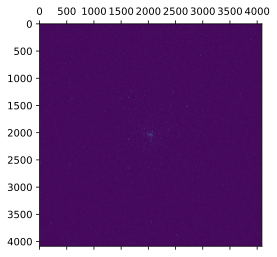

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
from matplotlib import style
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import matplotlib.pyplot as plt
from astropy.io import fits

with fits.open(fits_file) as result_file:
    result_data = result_file[1].data

fig1 = plt.figure()
im = plt.matshow(result_data)
plt.savefig('notebook_example_basic_scene.jpeg')

As well as a detail from the detector center.

<Figure size 432x288 with 0 Axes>

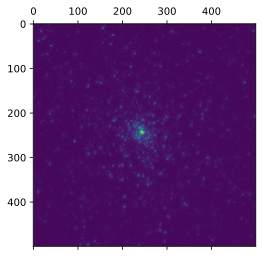

In [9]:
fig2 = plt.figure()
im2 = plt.matshow(result_data[1800:2300, 1800:2300])
plt.savefig('notebook_example_basic_scene.jpeg')